# Setup


In [13]:
from scripts.visualize_box_version import prepare_dataset_and_model
import numpy as np

args, model, train_dataset, box_data,box_file = prepare_dataset_and_model(args_location="test/partition_emb_box_250/args.json")

loading CLIP with cond_model at cpu
Checking for missing clip feats. This can be slow the first time.


100%|██████████| 149/149 [00:02<00:00, 64.85it/s]


model loaded!
training statistics collected


In [14]:
if "unit_box_mean" not in args:
        unit_box_mean = train_dataset.unit_box_mean
        unit_box_std = train_dataset.unit_box_std
else:
    unit_box_mean = np.array(args["unit_box_mean"])
    unit_box_std = np.array(args["unit_box_std"])

obj_idx2name = {v: k for k, v in train_dataset.classes.items()}
rel_idx2name = {k + 1: v for k, v in enumerate(train_dataset.relationships)}
rel_idx2name[0] = "belong to"
device = args['device']

# Retrieve One Graph from Train Dataset


In [23]:
# input idx of data in the dataset to retrieve the graph and corresponding data
from helpers.visualize_graph import visualize_scene_graph
query_idx = 2

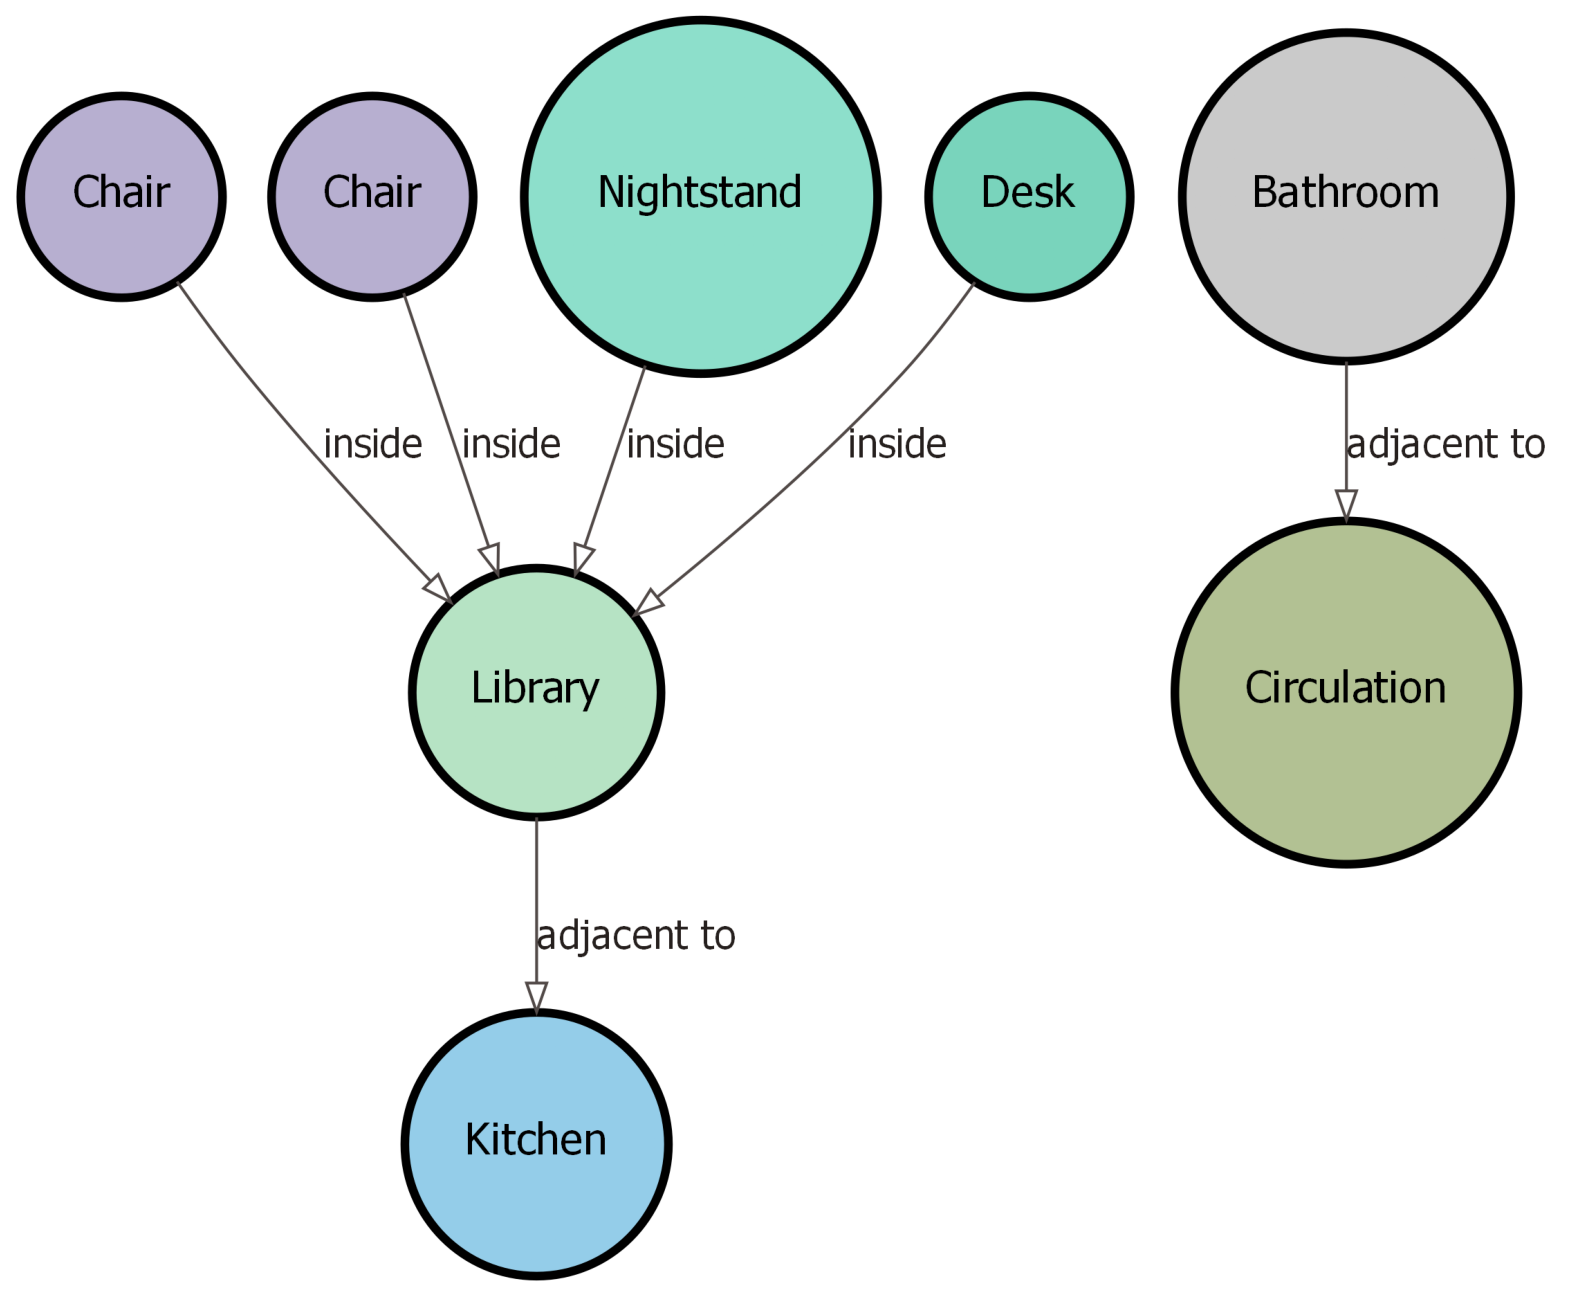

tensor([12,  9,  6,  5,  7, 10,  1,  5,  0])
tensor([[ 7,  8,  0],
        [ 7,  8,  0],
        [ 0,  4,  7],
        [ 0,  3,  7],
        [ 4,  8,  3],
        [ 4,  8,  3],
        [ 5, 14,  1],
        [ 3,  4,  4],
        [ 4,  8,  3],
        [ 0,  4,  7],
        [ 0,  4,  7],
        [ 7,  9,  4],
        [ 4,  8,  3],
        [ 0,  9,  3],
        [ 4, 10,  0],
        [ 0,  2,  3],
        [ 0,  4,  4],
        [ 3,  4,  7],
        [ 0,  4,  4],
        [ 4, 10,  7],
        [ 0,  9,  4],
        [ 0,  9,  3],
        [ 4, 10,  7],
        [ 3, 11,  4],
        [ 3,  4,  7],
        [ 4, 10,  3],
        [ 3, 13,  5],
        [ 6, 14,  2],
        [ 7,  9,  4],
        [ 4, 10,  3],
        [ 3,  4,  4],
        [ 0,  5,  3],
        [ 0,  5,  3],
        [ 3,  4,  4],
        [ 0,  9,  4],
        [ 7,  3,  3],
        [ 0,  9,  4],
        [ 7,  8,  0],
        [ 4,  4,  7],
        [ 7,  3,  4],
        [ 4, 10,  0],
        [ 3,  4,  7],
        [ 7, 11,  4],
        [

In [24]:

# parse data
data = train_dataset[query_idx]
dec_objs_grained = data["decoder"]["objs_grained"]
dec_objs = data["decoder"]["objs"]
dec_triples = data["decoder"]["triples"]
dec_rel_feat = data["decoder"]["rel_feats"]
dec_text_feat = data["decoder"]["text_feats"]
dec_unit_box = data["decoder"]["unit_box"]
obj_to_pidx = data["decoder"]["obj_to_pidx"]
boxes_gt = data["decoder"][
    "boxes"
]  # TODO: directly denormalization seems problematic, check!!
instances = data["instance_id"][0]
if "sdfs" in data["decoder"]:
    dec_sdfs = data["decoder"]["sdfs"]
scan = data["scan_id"][0]
dec_objs, dec_triples, dec_unit_box = (
    dec_objs.to(device),
    dec_triples.to(device),
    dec_unit_box.to(device),
)

visualize_scene_graph(
    dec_triples.numpy(),
    dec_objs.numpy(),
    obj_idx2name,
    rel_idx2name,
    obj_class_to_color=args["dataset"] + "/class_color.json",
    included_relations=[
        "inside",
        "adjacent to",
    ],
)

print(dec_objs)
print(dec_triples)

# Visualize Boxes using Plotly


In [18]:
from scripts.visualize_box_version import predict_boxes_and_angles,rationalize_box_params
from helpers.viz_util import render_plotly_sdf

# for custom bounding box input, change the is_custom_boundary to True, and put the input bbox array in unit_box 

boxes_pred_den, angles_pred,dec_unit_box = predict_boxes_and_angles(
    is_custom_boundary=False,  # True if custom bbox 
    device="cpu",
    random_seed=852,
    model=model,
    unit_box=None,
    args=args,
    data=data,
    unit_box_mean=unit_box_mean,
    unit_box_std=unit_box_std,
    box_file = box_file
)


In [19]:
box_points, denormalized_boxes, angles_pred = rationalize_box_params(
    boxes_pred_den, angles_pred, unit_box_mean, unit_box_std, dec_unit_box, data
)
render_plotly_sdf(
    box_points,

    obj_idx2name=obj_idx2name,
    objs=dec_objs,

    shapes_pred=None,

    render_shapes=False,

    render_boxes=True,

    colors=args["dataset"] + "/class_color.json",

    save_as_image=False,

    filename=f"{args['exp']}/scene_render.png",
    obj_to_pidx=obj_to_pidx,

)

# Export Meshes


In [9]:
import json
import os
from helpers.viz_util import create_scene_meshes,export_scene_meshes
detailed_obj_class = train_dataset.vocab["full_object_idx_to_name_grained"]
sdf_dir = "DEEPSDF_reconstruction/Meshes"
# get furniture category
fur_cat_file = args["dataset"] + "/cat_jid_all.json"
with open(fur_cat_file, "r") as file:
    fur_cat = json.load(file)
# trimesh mesh object
meshes = create_scene_meshes(
    dec_objs_grained,
    obj_to_pidx,
    denormalized_boxes,
    angles_pred,
    detailed_obj_class,
    fur_cat,
    sdf_dir,
    retrieve_sdf = False, # export box only meshes
)


In [12]:
exp_dir = os.path.join(args['exp'],'mesh')
mesh_name = f'{data["scan_id"]}.obj'
exp_path = os.path.join(exp_dir,mesh_name)
print(exp_path)
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir,exist_ok = True)
export_scene_meshes(meshes,dec_objs,obj_idx2name,exp_path)

test/partition_emb_box_250\mesh\00de1e24-ab10-4aef-bb72-130ca18d017c-4room.fbx
